In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [6]:
train_dir = '../data/train'
test_dir = '../data/test'

img_height, img_width = 48, 48
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


MODEL

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
898/898 [==============================] - 18s 17ms/step - loss: 1.8354 - accuracy: 0.2422 - val_loss: 1.7628 - val_accuracy: 0.2664 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - 15s 17ms/step - loss: 1.7729 - accuracy: 0.2701 - val_loss: 1.6346 - val_accuracy: 0.3572 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - 15s 17ms/step - loss: 1.6810 - accuracy: 0.3230 - val_loss: 1.5786 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 4/50
898/898 [==============================] - 15s 17ms/step - loss: 1.5988 - accuracy: 0.3656 - val_loss: 1.4514 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 5/50
898/898 [==============================] - 15s 17ms/step - loss: 1.5430 - accuracy: 0.3951 - val_loss: 1.3942 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 6/50
898/898 [==============================] - 15s 17ms/step - loss: 1.4983 - accuracy: 0.4167 - val_loss: 1.3591 - val_accuracy: 0.4714 - lr: 0.0010
Epoch 7/50
898/898 [==============================] - 15s 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

225/225 [==============================] - 2s 7ms/step - loss: 1.1606 - accuracy: 0.5574
Test Accuracy: 0.56


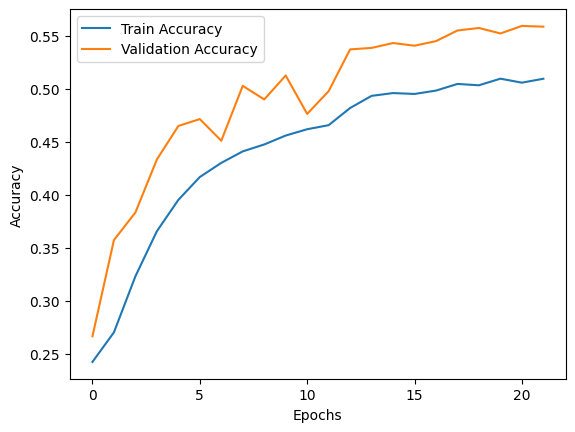

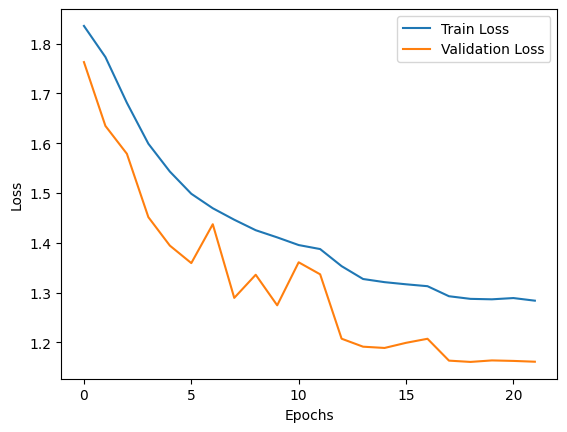

In [10]:
# Précision
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Détails erreurs

1/1 [==============================] - 0s 64ms/step


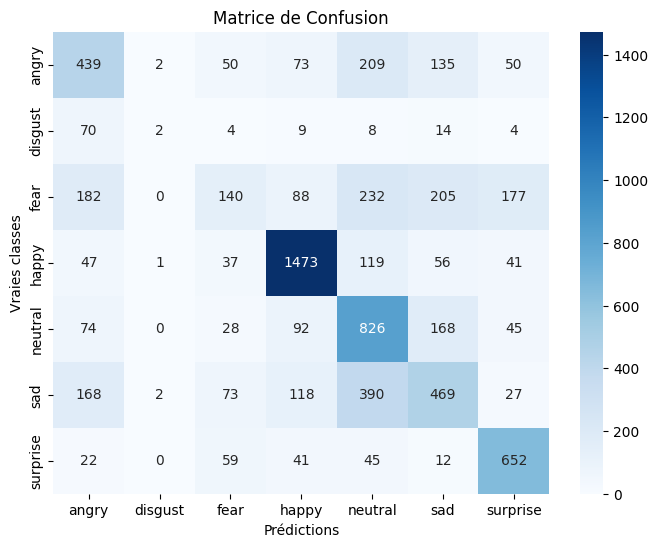

Classification Report:
              precision    recall  f1-score   support

       angry       0.44      0.46      0.45       958
     disgust       0.29      0.02      0.03       111
        fear       0.36      0.14      0.20      1024
       happy       0.78      0.83      0.80      1774
     neutral       0.45      0.67      0.54      1233
         sad       0.44      0.38      0.41      1247
    surprise       0.65      0.78      0.71       831

    accuracy                           0.56      7178
   macro avg       0.49      0.47      0.45      7178
weighted avg       0.54      0.56      0.53      7178



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Récupérer les vraies étiquettes et prédictions
y_true = []
y_pred = []

for batch in test_generator:
    X_batch, y_batch = batch
    y_true.extend(np.argmax(y_batch, axis=1))  # Labels réels
    y_pred.extend(np.argmax(model.predict(X_batch), axis=1))  # Prédictions

    if len(y_true) >= test_generator.samples:
        break  # Stopper quand on a toutes les prédictions

# Obtenir les noms des classes
class_labels = list(test_generator.class_indices.keys())

# 🔹 Générer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# 🔹 Affichage avec seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

# 🔹 Rapport détaillé des performances
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Test prédiction

In [14]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image


1/1 [==============================] - 0s 18ms/step


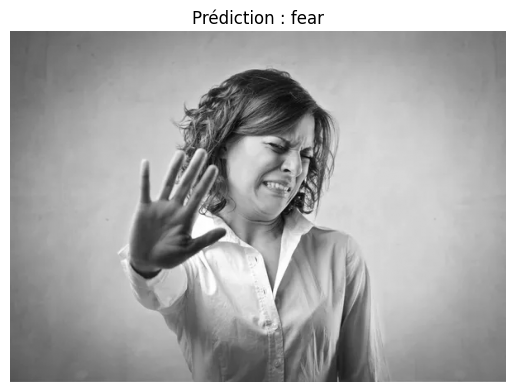

'fear'

In [25]:
def predict_emotion(model, img_path, class_names):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (48, 48))
    
    # Normalisation et ajout d'une dimension pour correspondre au batch
    img_input = img_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)
    img_input = np.expand_dims(img_input, axis=-1)

    # Prédiction
    prediction = model.predict(img_input)
    predicted_class = np.argmax(prediction)
    emotion = class_names[predicted_class]

    # Afficher l'image avec Matplotlib
    plt.imshow(img, cmap='gray')  # Affichage en niveaux de gris
    plt.title(f"Prédiction : {emotion}")
    plt.axis("off")  # Enlever les axes
    plt.show()

    return emotion

# Liste des classes d'émotions
class_names = list(train_generator.class_indices.keys())

# Tester avec une image
img_path = "../validation/deg1.jpg"
predict_emotion(model, img_path, class_names)
